# Qualifying

In [1]:
import fastf1
import fastf1.plotting
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from openpyxl.styles import PatternFill
from openpyxl import Workbook
from openpyxl import load_workbook
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.ticker as ticker


# enabling misc_mpl_mods will turn on minor grid lines that clutters the plot
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False)

In [2]:
ses = 4
race = 15

In [3]:
session = fastf1.get_session(2023,race,ses)
session.load()


req         WARNING 	

DEFAULT CACHE ENABLED!
	Cache directory: C:\Users\GTR\AppData\Local\Temp\fastf1.
	Size: 24.0 KB


core           INFO 	Loading data for Japanese Grand Prix - Qualifying [v3.1.2]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO

### Pre Defined

In [191]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)

compoundcolor = pd.DataFrame.from_dict(
    {
        1: ['HARD','#F0F0EC'], 
        2:['INTERMEDIATE', '#43B02A'], 
        3:['MEDIUM','#FFD12E'], 
        4:['SOFT', '#DA291C'], 
        5:['TEST-UNKNOWN', '#434649'], 
        6:['UNKNOWN','#00FFFF'], 
        7:['WET', '#0067AD']
    },
    orient='index',
    columns=['Compound', 'Color']
)

In [246]:
# getting laps of session
laps = session.laps 

# adding lap time in seconds
laps['LapTimeS'] = laps["LapTime"].dt.total_seconds()
laps["LapTimeS"] = laps["LapTimeS"] - 60 # correcting lap time

# adding lap time start in seconds
laps['LapStartTimeS'] = laps["LapStartTime"].dt.total_seconds()

# adding lap time end in seconds
laps['DeltaTime'] = 0 # add column Delta time filled with 0

# getting max lap of session
max_lap = int(session.laps["LapNumber"].max())

#results of race
results = session.results

# #correcting team color
# results["TeamColor"] = [fastf1.plotting.team_color(i) for i in results["TeamName"]] 

# drivers list
drivers = session.drivers

# Drivers Start order 
drivers_start = results[["DriverNumber","GridPosition"]].sort_values(by=['GridPosition'])
drivers_start = drivers_start["DriverNumber"].values

#drivers abreviation
drivers_abr = [session.get_driver(driver)["Abbreviation"] for driver in drivers]

# Drivers Start order 
drivers_start_abr = results[["Abbreviation","GridPosition"]].sort_values(by=['GridPosition'])
drivers_start_abr = drivers_start_abr["Abbreviation"].values

#race name 
race_name = session.event["EventName"]

### Top Speed Qualifying 

The DataFrame is empty driver:  2


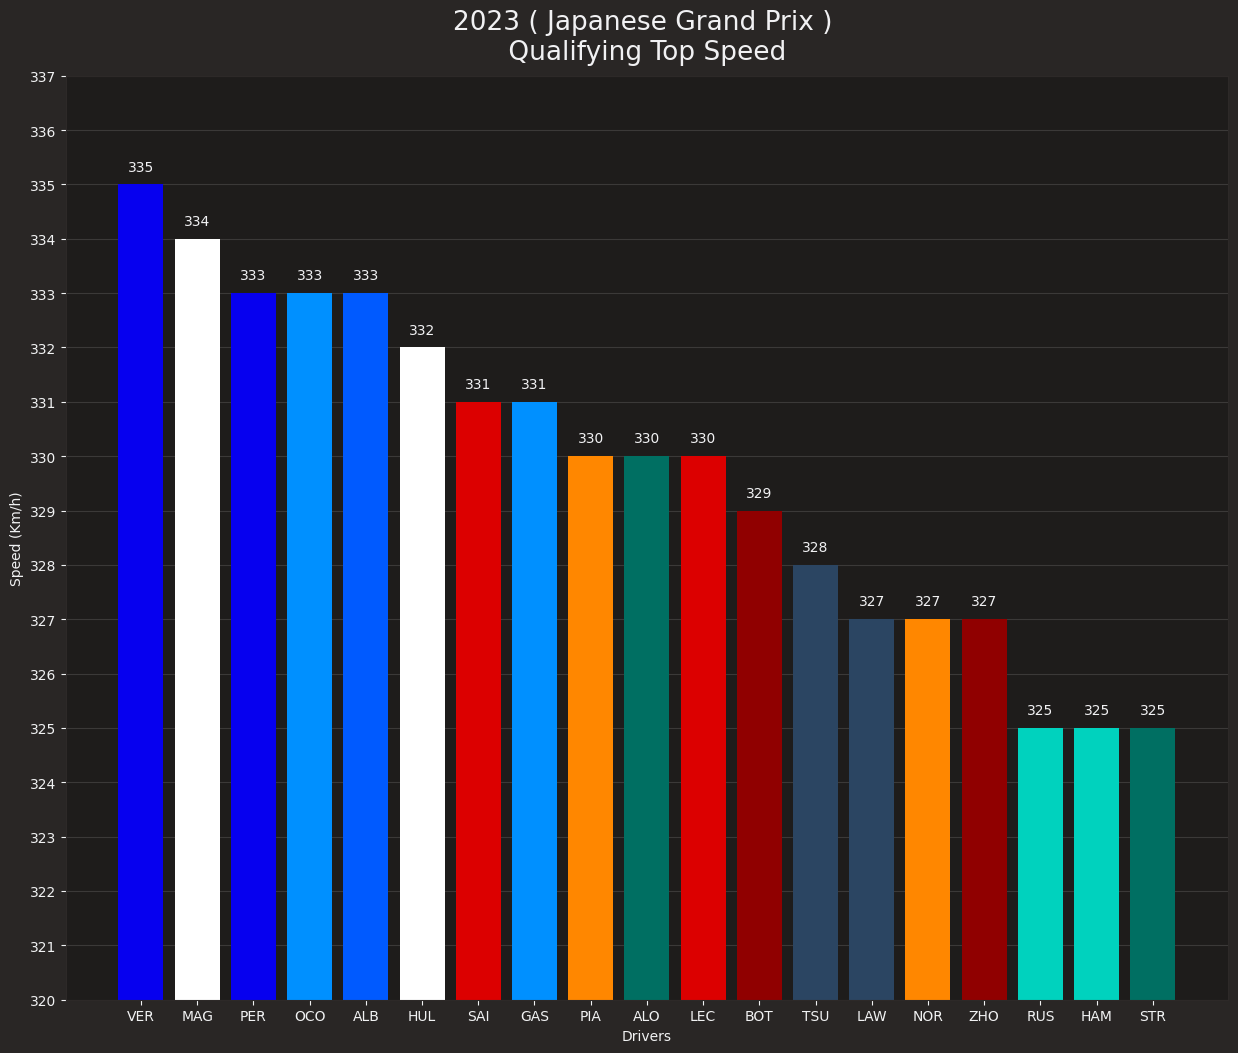

In [254]:
driver_list = []
DriverAB_list = []
top_speed_list = []
color_list = []

for i in drivers:
    lap = laps.loc[laps["DriverNumber"]==i]
    if (lap.empty or lap["LapTime"].isna().all()):
        print("The DataFrame is empty driver: ",i)
    else:
        max_speed = lap.pick_fastest().get_car_data()
        driver_list.append(i)
        DriverAB_list.append(results.loc[results["DriverNumber"] == i,"Abbreviation"].values[0])
        top_speed_list.append(max_speed["Speed"].max())
        color_list.append(fastf1.plotting.team_color(session.get_driver(i)["TeamName"]))

df_top_speed = pd.DataFrame({
    'DriverNumber': driver_list,
    'Driver': DriverAB_list,
    'TopSpeed': top_speed_list,
    'Color': color_list
})

df_top_speed = df_top_speed.sort_values(by='TopSpeed', ascending=False).reset_index(drop=True)

#Plotting Qualifying Lap Time

plt.figure(figsize=(15, 12))
x = df_top_speed["Driver"].reset_index(drop=True)
y = df_top_speed["TopSpeed"].reset_index(drop=True)

# Create the bar plot
plt.bar(x, y,color = df_top_speed["Color"])

# Add labels and title
plt.xlabel('Drivers')
plt.ylabel('Speed (Km/h)')
plt.title('2023 ( '+race_name+' ) \n Qualifying Top Speed ')
plt.yticks(range(int(df_top_speed["TopSpeed"].min())-20, int(df_top_speed["TopSpeed"].max())+4,1))
plt.ylim(int(df_top_speed["TopSpeed"].min())-5,int(df_top_speed["TopSpeed"].max()) +2)
plt.grid(axis='y', alpha=0.2)

# Add text annotations on top of bars
for i in range(len(x)):
    plt.text(i, y.loc[i]+0.2, str(y.loc[i]), ha='center', va='bottom')

# Save the figure and show
plt.savefig('C:/Users/GTR/Pictures/Graphes/Qualifying/2023_'+race_name+'_Qualifying_top_speed.png', dpi=200, bbox_inches='tight')
# Display the plot
plt.show()

### Lap time Qualifying

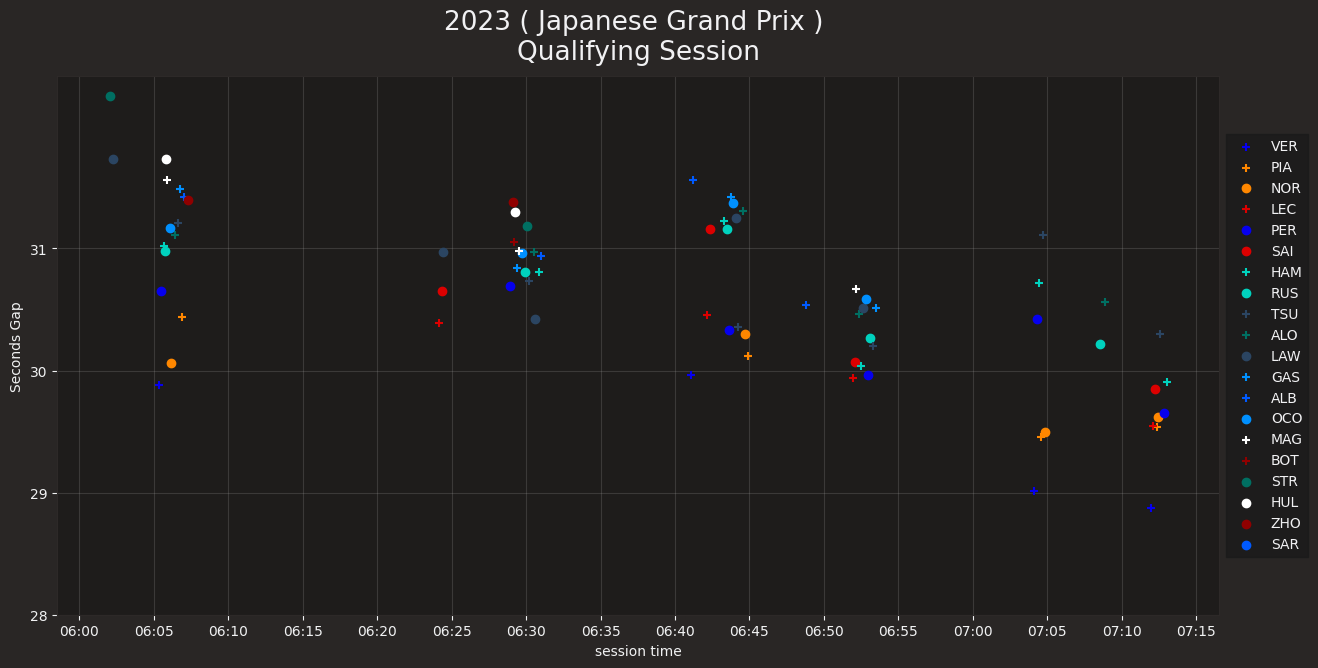

In [252]:
comp = " "
if comp == " ":
    laps_session = laps[["DriverNumber","Driver","LapNumber","LapStartDate","LapTime"]].pick_quicklaps()
else :  
    laps_session = laps[["DriverNumber","Driver","LapNumber","LapStartDate","Compound","LapTime"]].pick_compounds(comp).pick_quicklaps()
laps_session["LapTimeS"] = laps_session["LapTime"].dt.total_seconds()
laps_session["LapTimeS"] = laps_session["LapTimeS"] - 60
laps_session["LapStartDate"] = pd.to_datetime(laps_session["LapStartDate"])
laps_session["LapStartDateM"] = laps_session["LapStartDate"].dt.strftime('%H:%M')

# plotting graph

plt.figure(figsize=(15, 7))

color_picked = []
max_lap_time = int(laps_session["LapTimeS"].max())
min_lap_time = int(laps_session["LapTimeS"].min())

for i in drivers:
    lap_ordred = laps_session.loc[laps_session["DriverNumber"] == i].sort_values(by='LapStartDateM', ascending=True)
    x = lap_ordred["LapStartDate"]
    y = lap_ordred["LapTimeS"]

    driver_name = session.get_driver(i)["Abbreviation"]
    team_color = session.get_driver(i)["TeamColor"]
    
    if team_color in color_picked:
        plt.scatter(x, y, color=team_color, marker='o', label=driver_name)
    else:    
        plt.scatter(x, y, color=team_color, marker='+', label=driver_name)
        color_picked.append(team_color)
# Set the x-axis formatter
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# Set the x-axis locator
locator = mdates.MinuteLocator(interval=5)
plt.gca().xaxis.set_major_locator(locator)

# Customize the plot
plt.title('2023 ( '+session.event["EventName"]+' ) \nQualifying Session')
plt.xlabel('session time')
plt.ylabel('Seconds Gap')

plt.yticks(range(min_lap_time, max_lap_time, 1))

plt.grid(True, alpha=0.2)

# Add legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))



# Display the plot
plt.show()


### Qualifing Results 

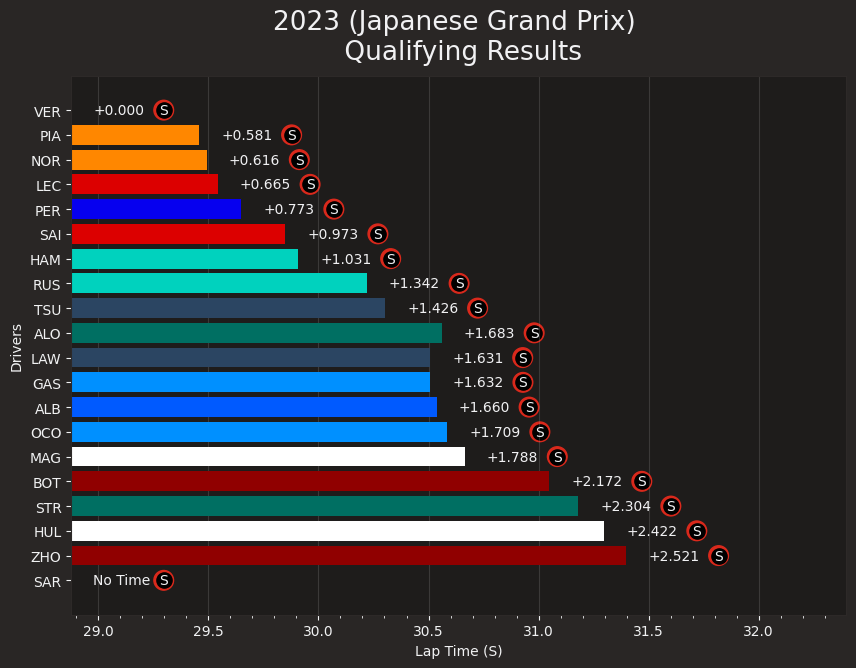

In [255]:
q1, q2, q3 = laps.split_qualifying_sessions()
q1_results = pd.DataFrame()
q2_results = pd.DataFrame()
q3_results = pd.DataFrame()
y=0
for i in drivers:
    y+=1
    if((q1.pick_driver(i).empty == False) & (y > 15)):
        if (q1.pick_driver(i).pick_fastest().isna().all()):
            lap = q1.pick_driver(i).pick_lap(1).T
        else:
            lap = q1.pick_driver(i).pick_fastest()
        q1_results = pd.concat([q1_results, pd.DataFrame(lap).T.reset_index(drop=True)], ignore_index=True)
    if((q2.pick_driver(i).empty == False) & (16 > y > 10)):
        if (q2.pick_driver(i).pick_fastest().isna().all()):
            lap = q2.pick_driver(i).pick_lap(1).T
        else:
            lap = q2.pick_driver(i).pick_fastest()
        q2_results = pd.concat([q2_results, pd.DataFrame(lap).T.reset_index(drop=True)], ignore_index=True)
    if((q3.pick_driver(i).empty == False) & (y < 11)):
        if (q3.pick_driver(i).pick_fastest().isna().all()):
            lap = q3.pick_driver(i).pick_lap(1).T
        else:
            lap = q3.pick_driver(i).pick_fastest()
        q3_results = pd.concat([q3_results, pd.DataFrame(lap).T.reset_index(drop=True)], ignore_index=True)
results_qualifying = pd.concat([q3_results,q2_results,q1_results], ignore_index=True).reset_index(drop=True)
# calculate gap to P1
results_qualifying['LapTimeS'] = results_qualifying['LapTimeS'].fillna(results_qualifying["LapTimeS"].min())
results_qualifying["DeltaTime"] = results_qualifying["LapTimeS"]-results_qualifying["LapTimeS"].min()
results_qualifying = pd.merge(results_qualifying, results[["DriverNumber","TeamColor"]], on='DriverNumber')
results_qualifying = pd.merge(results_qualifying, compoundcolor[["Compound","Color"]], on='Compound')


# Ploting Graph ------------------------------------

plt.figure(figsize=(10, 7))

# Load your logo image (replace 'logo.png' with the actual filename)
# logo = plt.imread('logo/LogoFomulaRcmDark.png')

y = results_qualifying["Driver"]
x = results_qualifying["LapTimeS"]
minx = results_qualifying["LapTimeS"].min()
maxx = results_qualifying["LapTimeS"].max()
color = results_qualifying["TeamColor"]
# Create the horizontal bar plot
plt.barh(y,x , color = color)
plt.scatter(x+0.42,y , color = results_qualifying["Color"], marker='o', s=200, zorder=0)
plt.scatter(x+0.42,y , color = "Black", marker='o', s=120, zorder=0)

# Set labels and title
plt.xlabel('Lap Time (S)')
plt.ylabel('Drivers')
plt.title('2023 ('+session.event["EventName"]+') \n Qualifying Results')
plt.xticks(range(80, 95, 1))
plt.xlim(minx, maxx+1)
plt.gca().invert_yaxis()
# Set the y-axis ticker to display integer values with increments of 0.1
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=0.1))

plt.grid(axis='x',alpha = 0.2)


# Add text annotations near each bar
for i in range(0,len(y)):
    if ((i > 0) and (results_qualifying["DeltaTime"][i] == 0)):
        plt.text(results_qualifying["LapTimeS"][i] + 0.1, i,"No Time", va='center')       
    else:
        plt.text(results_qualifying["LapTimeS"][i] + 0.1, i, "+"+"{:.3f}".format(results_qualifying["DeltaTime"][i]), va='center')
        
    
    plt.text(results_qualifying["LapTimeS"][i] + 0.4, i,results_qualifying["Compound"][i][0], va='center')


# Display the plot
plt.savefig('C:/Users/GTR/Pictures/Graphes/Qualifying/2023_'+race_name+'_Results_Qualifying.png', dpi=200, bbox_inches='tight')

plt.show()